In [134]:
import numpy as np
from scipy.stats import norm, laplace, cauchy, multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(8)

In [135]:
import wesanderson as wes

sns.set_palette(sns.color_palette(wes.film_palette('Darjeeling Limited')))

### Utility Functions


In [132]:
def traceplot(samples, w=6, h=4, overlay=True, n_col=2):
    # samples: [#components, #iterations]
    
    n_component = samples.shape[0]
    n_iter = samples.shape[1]

    if overlay:
        fig, ax = plt.subplots(figsize=(6,4))
        
        for i in range(n_component):
            sns.lineplot(x=range(1, n_iter+1), y=samples[i, :], label=rf'$X_{i+1}$', linewidth=0.5, legend=False)

        # Set labels
        ax.set_xlabel('t')
        ax.set_ylabel(r'$X_i(t)$')

        # Create figure-level legend outside the plot
        fig.legend(loc='upper left', bbox_to_anchor=(0.9, 0.9), frameon=False)

        # Modify the line width in the legend
        legend = fig.legends[0]
        for line in legend.get_lines():
            line.set_linewidth(1)
        
        plt.show()
    else:
        n_row = np.ceil(n_component / n_col).astype(int)

        fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(w*n_col, h*n_row))

        for i in range(n_component):
            ax = axes.flat[i]
            
            sns.lineplot(x=range(1, n_iter+1), y=samples[i, :], ax=ax, linewidth=0.5)
            
            # Set labels
            ax.set_xlabel('t')
            ax.set_ylabel(r'$X_i(t)$')

        # Delete any unused axes (if there are fewer features than subplot slots)
        for i in range(n_component, len(axes.flat)):
            fig.delaxes(axes.flat[i])

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()                     

### Log Distributions


In [122]:
def logpi_normal(x, location=0, scale=1):
    return np.sum(norm.logpdf(x, loc=location, scale=scale))

def logpi_laplace(x, location=0, scale=1):
    return np.sum(laplace.logpdf(x, loc=location, scale=scale))

def logpi_cauchy(x, location=0, scale=1):
    return np.sum(cauchy.logpdf(x, loc=location, scale=scale))

def logpi_mvnormal(x, location=[0], covariance=[1]):
    return np.sum(multivariate_normal(x, mean=location, cov=covariance))

In [147]:
def grad_logpi_normal(x, location=0, scale=1):
    return  - (x - location) /scale**2

def grad_logpi_laplace(x, location=0, scale=1):
    return - np.sign(x - location) / scale

def grad_logpi_cauchy(x, location=0, scale=1):
    return - 2*(x - location) / (scale**2 + (x - location)**2)

### MCMC Algorithms


In [148]:
def random_walk_proposal(x, step_size):
    return x + step_size * np.random.normal(size=len(x))


def random_walk_mh(logpi, n_iter, step_size, x_init, *args):
    # Matrix to store the sampled values from the chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of the target distribution at the current state
    x = x_init
    logpi_x = logpi(x, *args)

    for i in range(n_iter):
        # Propose a candidate move
        y = random_walk_proposal(x, step_size)
        logpi_y = logpi(y, *args)

        # Calculate the difference in the log-probabilities of the proposed and
        # current states (i.e. \log \frac{\pi(y)}{\pi(x)})
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update the current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted += 1

        # Store the current state
        x_samples[:, i] = x

    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate

In [149]:
def barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y):
    logq_xy = - np.log1p(np.exp(- (y - x) * grad_logpi_x))
    logq_yx = - np.log1p(np.exp(- (x - y) * grad_logpi_y))

    return np.sum(logq_yx - logq_xy)


def barker_proposal(x, grad_logpi_x, step_size=1):
    z = np.random.normal(size=len(x), scale=2) * step_size

    # Direction
    threshold = 1 / (1 + np.exp(- grad_logpi_x * z))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + b * z
    

def barker_mh(logpi, grad_logpi, n_iter, x_init, step_size=1, *args):
    # Matrix to store the sampled values from the chain (#components, #iterations)
    x_samples = np.empty((len(x_init), n_iter))

    # Counter for accepted proposals
    accepted = 0

    # Log of the target distribution at the current state
    x = np.array(x_init)
    logpi_x = logpi(x, *args)
    
    for i in range(n_iter):
        grad_logpi_x = grad_logpi(x, *args)

        # Propose a candidate move
        y = barker_proposal(x, grad_logpi_x, step_size)
        logpi_y = logpi(y, *args)
        grad_logpi_y = grad_logpi(y, *args)

        # Calculate the Barker acceptance rate
        logq_ratio = barker_logq_ratio(x, y, grad_logpi_x, grad_logpi_y)
        log_acceptance = logpi_y - logpi_x + logq_ratio
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            # If accepted, update the current state and log-probability
            x = y
            logpi_x = logpi_y
            accepted +=1

        # Store the current state
        x_samples[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return x_samples, acceptance_rate 

### Experiments


Acceptance rate:0.2275


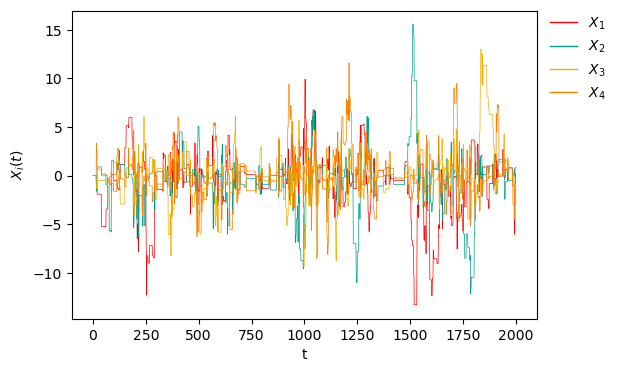

Sample quantiles
[[-1.34710835 -1.17535975 -1.11616344 -0.86617491]
 [-0.18130822 -0.2009016  -0.12788187 -0.09237496]
 [ 0.81311598  0.68712668  0.80677758  0.96491766]]
Actual quantiles
[-1.  0.  1.]


In [150]:
samples, accept_rate = random_walk_mh(logpi=logpi_cauchy, n_iter=2000, step_size=2.5, x_init=np.array([0, 0, 0, 0]))

print(f'Acceptance rate:{accept_rate}')

traceplot(samples)

print('Sample quantiles')
print(np.quantile(samples, [0.25, 0.5, 0.75], axis=1))
print('Actual quantiles')
print(cauchy.ppf([0.25, 0.5, 0.75], loc=0, scale=1))

Acceptance rate:0.51044


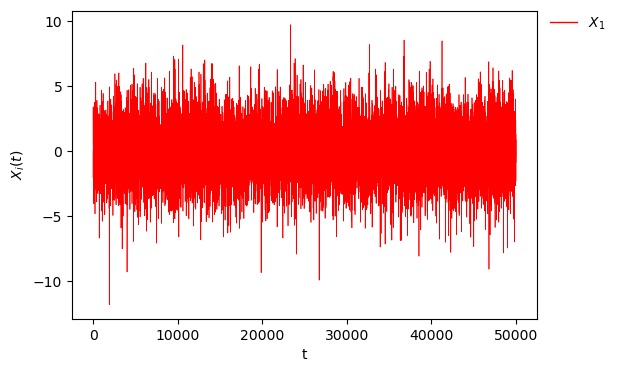

Sample quantiles
[[-0.6962387 ]
 [-0.01175694]
 [ 0.70601564]]
Actual quantiles
[-0.69314718  0.          0.69314718]


In [152]:
samples, accept_rate = barker_mh(logpi=logpi_laplace, grad_logpi=grad_logpi_laplace, n_iter=50000, x_init=np.array([0]), step_size=2)

print(f'Acceptance rate:{accept_rate}')

traceplot(samples)

print('Sample quantiles')
print(np.quantile(samples, [0.25, 0.5, 0.75], axis=1))
print('Actual quantiles')
print(laplace.ppf([0.25, 0.5, 0.75], loc=0, scale=1))